In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd 
from transformers import BertTokenizer, BertModel
import torch


import mlflow
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE
import seaborn as sns
from sentence_transformers import SentenceTransformer

import time
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, hamming_loss, jaccard_score



/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fonctions

In [2]:
def select_top_n_tags(probabilities, threshold, top_n=5):
    """ Sélectionne les top N tags pour chaque échantillon en fonction d'un seuil de probabilité."""

    # Créer une matrice de zéros de la même forme que probabilities
    final_tags = np.zeros(probabilities.shape)
    
    for i in range(probabilities.shape[0]):
        # Trouver les indices qui satisfont le seuil
        eligible_indices = np.where(probabilities[i] >= threshold)[0]
        
        # Trier ces indices en fonction de leur probabilité
        top_indices = eligible_indices[np.argsort(probabilities[i][eligible_indices])][::-1]
        
        # Sélectionner les top N indices
        top_n_indices = top_indices[:top_n]
        
        # Mettre à 1 les positions correspondant aux tags sélectionnés
        final_tags[i, top_n_indices] = 1
    
    return final_tags



In [3]:
def plot_result(model_results):
    """Fonction pour afficher le graphiques des résultats des modèles
        Log les graphiques dans mlflow"""
    # Largeur des barres
    barWidth = 0.2
    title = str(model_results.iloc[0,0])
    # Position des barres sur l'axe x
    r1 = np.arange(len(model_results['Vectorizer']))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(6,5))

    # Créer les barres
    plt.bar(r1, model_results['precision Test'], width = barWidth, color = 'blue', edgecolor = 'grey', label='Precision Test')
    plt.bar(r2, model_results['Jaccard Test'], width = barWidth, color = 'cyan', edgecolor = 'grey', label='Jaccard Test')

    # Ajouter des xticks 
    plt.title(title, fontweight='bold', fontsize = 15)
    plt.xlabel(title, fontweight='bold', fontsize = 15)
    plt.ylabel('Score', fontweight='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(model_results['Vectorizer']))], model_results['Vectorizer'])

    plt.legend()
    plt.savefig(title+".png")
    mlflow.log_artifact(title+".png")
    plt.show()

In [4]:
def stocker_results(name = str, precision_test=None, recall_test=None,f1_test=None,jaccard_test=None, fit_time=None, transform_time=None, predict_time=None, model=None, X_test=None, y_test=None):
    """Fonction pour stocker les résultats des modèles dans un DataFrame
        Log les résultats dans mlflow"""
    results = pd.DataFrame({'Vectorizer': [name], 'precision Test': [precision_test], 'recall_test':[recall_test],'f1_test':[f1_test],'Jaccard Test': [jaccard_test],'Fit Time': [fit_time], 'predict_time': [predict_time]})
    display(results)
    mlflow.log_metric("Jaccard Score", jaccard_test)
    mlflow.log_metric("Precision", precision_test)
    mlflow.log_metric("Recall", recall_test)
    mlflow.log_metric("F1 Score", f1_test)
    mlflow.log_metric("Fit_time", fit_time)
    mlflow.log_metric("prediction_time", predict_time)
    return results

In [5]:
def tags_predicted_to_text(tags_predicted, mlb):
    """Fonction pour transformer les tags prédits en texte
        Log les résultats dans mlflow"""
    predictions_labels =mlb.inverse_transform(tags_predicted)
    predictions_labels= pd.DataFrame(predictions_labels)
    predictions_labels.to_csv("Data/predictions_labels.csv", index=False)
    mlflow.log_artifact("Data/predictions_labels.csv")

In [6]:
def words_tokenize(text):
    text = text.split()
    return text

In [7]:
data = pd.read_csv('Data/df_tags_filtered.csv')
# Combinaison des colonnes Title et Body
data['combined'] = data['Title'] + " " + data['Body']

display(data)

,Title,Body,Tags,Body_word_count,combined
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,android android-architecture-components bottom...,131,android jetpack navigation bottomnavigationvie...
1,jetpack compose button drawable,achieve jetpack compose something button eleva...,android android-jetpack-compose android-compos...,60,jetpack compose button drawable achieve jetpac...
2,topappbar flash navigate compose navigation,screen scaffold topappbar navigate jetpack nav...,android android-jetpack android-jetpack-compos...,198,topappbar flash navigate compose navigation sc...
3,how create recycler view compose jetpack,special way create recyclerview compose jetpac...,android android-recyclerview android-jetpack-c...,7,how create recycler view compose jetpack speci...
4,how navhostfragment,integrate android navigation architecture comp...,android android-fragments android-architecture...,48,how navhostfragment integrate android navigati...
...,...,...,...,...,...
33574,spring rest json can handle managedback refere...,post httplocalhosttranslators angularjs fronte...,java json hibernate jackson spring-boot,273,spring rest json can handle managedback refere...
33575,disableenable submit button form fill,form submit button disabledenabled depend form...,javascript forms submit disabled-control,56,disableenable submit button form fill form sub...
33576,how keep net console app run,consider console application start service sep...,c# multithreading sleep manualresetevent,53,how keep net console app run consider console ...
33577,how avoid javalangnoclassdeffounderror,code add text exist doc file itll save another...,java apache-poi noclassdeffounderror doc,165,how avoid javalangnoclassdeffounderror code ad...


In [8]:
# tansformation en liste

data['Body'] = data.Body.apply(lambda text: words_tokenize(text))
data['Title'] = data.Title.apply(lambda text: words_tokenize(text))
data['Tags'] = data.Tags.apply(lambda text: words_tokenize(text))
display(data)

,Title,Body,Tags,Body_word_count,combined
0,"[android, jetpack, navigation, bottomnavigatio...","[android, jetpack, navigation, bottomnavigatio...","[android, android-architecture-components, bot...",131,android jetpack navigation bottomnavigationvie...
1,"[jetpack, compose, button, drawable]","[achieve, jetpack, compose, something, button,...","[android, android-jetpack-compose, android-com...",60,jetpack compose button drawable achieve jetpac...
2,"[topappbar, flash, navigate, compose, navigation]","[screen, scaffold, topappbar, navigate, jetpac...","[android, android-jetpack, android-jetpack-com...",198,topappbar flash navigate compose navigation sc...
3,"[how, create, recycler, view, compose, jetpack]","[special, way, create, recyclerview, compose, ...","[android, android-recyclerview, android-jetpac...",7,how create recycler view compose jetpack speci...
4,"[how, navhostfragment]","[integrate, android, navigation, architecture,...","[android, android-fragments, android-architect...",48,how navhostfragment integrate android navigati...
...,...,...,...,...,...
33574,"[spring, rest, json, can, handle, managedback,...","[post, httplocalhosttranslators, angularjs, fr...","[java, json, hibernate, jackson, spring-boot]",273,spring rest json can handle managedback refere...
33575,"[disableenable, submit, button, form, fill]","[form, submit, button, disabledenabled, depend...","[javascript, forms, submit, disabled-control]",56,disableenable submit button form fill form sub...
33576,"[how, keep, net, console, app, run]","[consider, console, application, start, servic...","[c#, multithreading, sleep, manualresetevent]",53,how keep net console app run consider console ...
33577,"[how, avoid, javalangnoclassdeffounderror]","[code, add, text, exist, doc, file, itll, save...","[java, apache-poi, noclassdeffounderror, doc]",165,how avoid javalangnoclassdeffounderror code ad...


In [9]:
X = data[['Title','Body']]  # features
y = data['Tags']       # target


df = pd.DataFrame(data)
def merge_and_keep_first_occurrence(row):
    merged = row['Title'] + row['Body']
    return list(dict.fromkeys(merged))
# Appliquer la fonction à chaque ligne du DataFrame
df['Merged'] = data.apply(merge_and_keep_first_occurrence, axis=1)

X = df['Merged']


In [10]:
# Séparation des données en train et test sets. 
# Sélection d'un sample pour accélérer le processus de test
X_train, X_test, y_train, y_test = train_test_split(X,y,
    test_size=0.2,
    random_state=42
)


display(X_train.shape, X_test.shape)
X_train_sample = X_train.sample(1000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]
X_test_sample = X_test.sample(200, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

(26863,)

(6716,)

In [11]:
print(X_train_sample.shape, X_test_sample.shape)
print(y_test_sample.shape, y_train_sample.shape)

(1000,) (200,)
(200,) (1000,)


## Pipeline vectorisation

In [12]:
from xgboost import XGBClassifier



class CustomTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=0.008, max_df=0.9, ngram_range=(1, 1), norm='l2', use_idf=True, stop_words='english'):
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.norm = norm
        self.use_idf = use_idf
        self.stop_words = stop_words
        self.vectorizer = TfidfVectorizer(min_df=self.min_df, max_df=self.max_df,
                                          ngram_range=self.ngram_range, norm=self.norm,
                                          use_idf=self.use_idf, stop_words=self.stop_words)

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X)
    


class CustomWord2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=400):  #, vector_size=400, window=8, min_count=6,alpha=0.025, epochs=5,workers=5, sg=0, max_vocab_size=None
        self.vector_size = vector_size
        '''self.window = window
        self.min_count = min_count
        self.alpha = alpha
        self.epochs = epochs
        self.workers = workers
        self.sg = sg
        self.max_vocab_size = max_vocab_size'''
        self.model = Word2Vec(
            vector_size=self.vector_size, 
            #window=self.window, 
            #workers=self.workers, 
            #sg=self.sg
        )
    def fit(self, X, y=None):
        self.model = Word2Vec(
            vector_size=self.vector_size
            
        )
        self.model.build_vocab(X)
        return self

    def transform(self, X, y=None):
        # Moyenne des vecteurs de mots pour chaque document
        return np.array([np.mean([self.model.wv[w] for w in words if w in self.model.wv]
                                 or [np.zeros(self.model.vector_size)], axis=0)
                         for words in X])


'''window=self.window, 
            min_count=self.min_count,
            alpha=self.alpha,
            workers=self.workers,
            sg=self.sg,
            max_vocab_size=self.max_vocab_size'''

class CustomBERTVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=128):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Tokenization
        inputs = self.tokenizer(X, padding=True, truncation=True, max_length=self.max_length, return_tensors="pt")
        
        # Passer les inputs à travers BERT
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Récupérer la représentation des tokens CLS (premier token)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        
        return embeddings



class SentenceTransformerVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.model.encode(X)
    

def create_tfidf_pipeline():
    pipeline_tfidf = Pipeline([
        
        ("tfidf", TfidfVectorizer(min_df=0.007, max_df=0.9, ngram_range=(1, 1), stop_words='english')),
        #('mlb', MultiLabelBinarizer()),
        ("clf", OneVsRestClassifier(LogisticRegression())),
    ])
    return pipeline_tfidf

def create_random_forest_pipeline():
    pipeline_rf = Pipeline([
        ("tfidf", CustomTfidfVectorizer()),
        ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    return pipeline_rf

def create_XGB_pipeline():
    pipeline_xgb = Pipeline([
        ("tfidf", CustomTfidfVectorizer()),
        ("XGB", XGBClassifier())
    ])
    return pipeline_xgb
def create_word2vec_pipeline():
    pipeline_word2vec = Pipeline([
        ("word2vec", CustomWord2VecVectorizer()),
        ("clf_w2v", OneVsRestClassifier(LogisticRegression())),

    ])
    return pipeline_word2vec

def create_bert_pipeline():
    pipeline_bert = Pipeline([
        ("bert_vectorizer", CustomBERTVectorizer()),
        ("clf_bert", OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    ])
    return pipeline_bert

def create_use_pipeline():
    pipeline_use = Pipeline([
        ("use_vectorizer", SentenceTransformerVectorizer()),
        
    ])
    return pipeline_use



In [13]:
print(y_train_sample[:10])

342      [android, user-interface, android-support-libr...
11837    [c#, asp.net-mvc, linq, entity-framework, asp....
31584       [java, collections, null, java-8, java-stream]
14632    [javascript, jquery, script-tag, javascript-in...
24015    [css, svg, reactjs, material-design, material-ui]
19968    [c#, asp.net, google-chrome, listbox, autopost...
8458     [c#, visual-studio, visual-studio-2013, intell...
20386    [ios, xcode, label, nsattributedstring, center...
15009    [sql, sql-server, sql-server-2008, stored-proc...
10601    [c#, winforms, datagridview, datatable, backgr...
Name: Tags, dtype: object


In [14]:
# Instanciation de MLB et transformation des labels
mlb = MultiLabelBinarizer()
y_train_sample_trans = mlb.fit_transform(y_train_sample)
y_test_sample_trans = mlb.transform(y_test_sample) 


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['abstraction', 'all-files', 'anaconda', 'android-5.1.1-lollipop', 'android-alertdialog', 'android-appwidget', 'android-cursor', 'android-framelayout', 'android-handler', 'android-implicit-intent', 'android-intentservice', 'android-multidex', 'angular2-routing', 'apache-commons', 'apache-kafka', 'apache2.4', 'apple-m1', 'application-pool', 'array-merge', 'assemblyversionattribute', 'browserify', 'c#-2.0', 'c-strings', 'calayer', 'calendar', 'capitalization', 'case', 'cellular-automata', 'character-properties', 'character-replacement', 'circular-buffer', 'client-side-scripting', 'cobertura', 'code-coverage', 'combinatorics', 'compare-and-swap', 'compression', 'concurrent-programming', 'content-type', 'continuous-integration', 'convenience-methods', 'conways-game-of-life', 'cookies', 'copy-paste', 'crash', 'css-animations', 'curly-braces', 'custom-errors', 'dag

## Vectorisation avec TF_IDF.
  Régréssion logistique:  

  RandomForest: 

  XGBoost: 

  Jaccard Score : C'est la taille de l'intersection des labels prédits et des vrais labels divisée par la taille de l'union des labels prédits et des vrais labels. C'est une bonne métrique pour la classification multilabels car elle prend en compte la présence et l'absence de chaque label.

  Precision, Recall, F1 Score : Ces métriques peuvent également être utilisées dans le contexte multilabels, en calculant la métrique pour chaque label individuellement, puis en prenant la moyenne.

In [15]:
from sklearn.model_selection import GridSearchCV

'''
pipeline_tfidf_grid = create_tfidf_pipeline()
param_grid_tfidf = {
    'tfidf__min_df': [1, 5, 10],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__use_idf': [True, False],
    
}

grid_search = GridSearchCV(
    pipeline_tfidf_grid, param_grid=param_grid_tfidf, 
    cv=5,scoring=['f1_weighted'] ,verbose=1, refit='f1_weighted')

# Convertir la matrice CSR en une liste de listes de mots
#X_train_sample_trans_list = [row.nonzero()[1].tolist() for row in X_train_sample]

# Entraîner le modèle Word2Vec
grid_search.fit(X_train_sample_str, y_train_sample_trans)

#grid_search.fit(X_train_sample_trans, y_train_sample_trans)

print("Meilleurs hyperparamètres : ", grid_search.best_params_)'''

'\npipeline_tfidf_grid = create_tfidf_pipeline()\nparam_grid_tfidf = {\n    \'tfidf__min_df\': [1, 5, 10],\n    \'tfidf__max_df\': [0.5, 0.75, 1.0],\n    \'tfidf__ngram_range\': [(1, 1), (1, 2), (1, 3)],\n    \'tfidf__norm\': [\'l1\', \'l2\'],\n    \'tfidf__use_idf\': [True, False],\n    \n}\n\ngrid_search = GridSearchCV(\n    pipeline_tfidf_grid, param_grid=param_grid_tfidf, \n    cv=5,scoring=[\'f1_weighted\'] ,verbose=1, refit=\'f1_weighted\')\n\n# Convertir la matrice CSR en une liste de listes de mots\n#X_train_sample_trans_list = [row.nonzero()[1].tolist() for row in X_train_sample]\n\n# Entraîner le modèle Word2Vec\ngrid_search.fit(X_train_sample_str, y_train_sample_trans)\n\n#grid_search.fit(X_train_sample_trans, y_train_sample_trans)\n\nprint("Meilleurs hyperparamètres : ", grid_search.best_params_)'

In [16]:
pipeline_tfidf = create_tfidf_pipeline()

# Convertir les listes en chaînes de caractères
X_train_sample_str = [' '.join(text) for text in X_train_sample]
X_test_sample_str = [' '.join(text) for text in X_test_sample]

# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans = pipeline_tfidf["tfidf"].fit_transform(X_train_sample_str)
X_test_sample_trans = pipeline_tfidf["tfidf"].transform(X_test_sample_str)


### Regression logistique OneVsRestClassifier

In [17]:
mlflow.set_experiment("MLflow Quickstart")
mlflow.end_run()
mlflow.start_run(run_name="TF-IDF-LogisticRegression")

<ActiveRun: >

In [18]:
fit_time =time.time()
lr_tfidf = pipeline_tfidf.named_steps['clf'].fit(X_train_sample_trans, y_train_sample_trans)
fit_time = time.time() - fit_time


predict_time = time.time()
predictions = lr_tfidf.predict_proba(X_test_sample_trans)
predict_time = time.time() - predict_time

print("shape de prediction",predictions.shape)
print("shape de prediction",X_test_sample_trans.shape)

mlflow.log_param("min_df", pipeline_tfidf.named_steps['tfidf'].min_df)
mlflow.log_param("max_df", pipeline_tfidf.named_steps['tfidf'].max_df)
mlflow.log_metric("fit_time", fit_time)
mlflow.sklearn.log_model(lr_tfidf, "model")


shape de prediction (200, 1674)
shape de prediction (200, 1048)


In [19]:
probabilities = predictions
# Utiliser la fonction pour selectionner les tags les plus probables
binary_predictions = select_top_n_tags(probabilities, threshold=0.2, top_n=7)

In [20]:
# Calcul des scores
precision_test = precision_score(y_test_sample_trans, binary_predictions, average='samples')
recall_test = recall_score(y_test_sample_trans, binary_predictions, average='samples')
f1_test = f1_score(y_test_sample_trans, binary_predictions, average='samples')
jaccardScore =jaccard_score(y_test_sample_trans, binary_predictions, average='samples')
print("Jaccard Score:" , jaccardScore)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)



Jaccard Score: 0.19266666666666665
Precision: 0.5275
Recall: 0.20241666666666666
F1 Score: 0.2764642857142857


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Transformation des tags prédits en texte
tags_predicted_to_text(binary_predictions, mlb)

In [22]:
# Calculer le nombre total de tags prédits
total_predicted_tags = binary_predictions.sum()

# Calculer le nombre total de tags possibles
total_possible_tags = y_test_sample_trans.size

# Calculer le taux de remplissage
fill_rate = total_predicted_tags / total_possible_tags

print(f'Taux de remplissage des tags : {fill_rate * 100:.2f}%')

Taux de remplissage des tags : 0.05%


In [23]:
# Afficher les metrics de classification
result_lr_tfidf = stocker_results(name="lr_Tfidf", 
                                precision_test=precision_score(y_test_sample_trans, binary_predictions, average='samples'),
                                f1_test=f1_score(y_test_sample_trans, binary_predictions, average='samples'),
                                recall_test = recall_score(y_test_sample_trans, binary_predictions, average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, binary_predictions, average='samples'), 
                                fit_time=fit_time, predict_time = predict_time)

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test,Fit Time,predict_time
0,lr_Tfidf,0.5275,0.202417,0.276464,0.192667,8.126969,0.123057


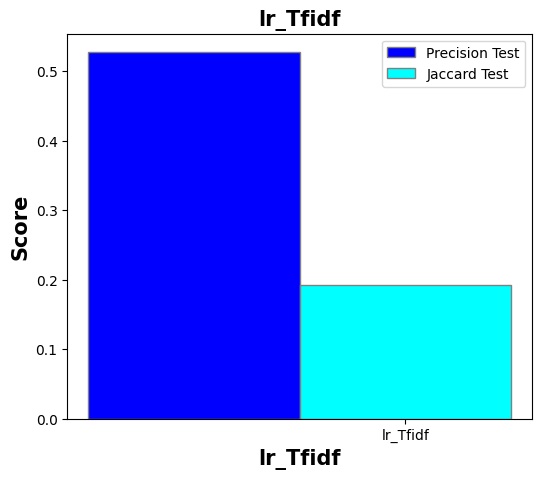

In [24]:
plot_result(result_lr_tfidf)

In [25]:
mlflow.end_run()

XGBOOST

In [26]:
mlflow.start_run(run_name="XGB-Classifier")

<ActiveRun: >

In [27]:
xgb_tfidf = create_XGB_pipeline()
# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans = xgb_tfidf["tfidf"].fit_transform(X_train_sample_str)
X_test_sample_trans = xgb_tfidf["tfidf"].transform(X_test_sample_str)


In [28]:
fit_time_xgb =time.time()
xgb_tfidf.fit(X_train_sample_str, y_train_sample_trans)
fit_time_xgb = time.time() - fit_time_xgb
print("Fit time : ", fit_time)

predict_time_xgb = time.time()
predictions_xgb = xgb_tfidf.predict(X_test_sample_str)
predict_time_xgb = time.time() - predict_time_xgb



Fit time :  8.12696886062622


In [29]:
# Utiliser la fonction pour obtenir les tags prédits
xgb_binary_predictions = select_top_n_tags(predictions_xgb, threshold=0.15, top_n=5)

print("Precision:", precision_score(y_test_sample_trans, xgb_binary_predictions, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, xgb_binary_predictions, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, xgb_binary_predictions, average='samples'))
#rf_predictions_labels =mlb.inverse_transform(rf_binary_predictions)
tags_predicted_to_text(xgb_binary_predictions, mlb)


Precision: 0.4986666666666666
Recall: 0.25475000000000003
F1 Score: 0.3131150793650794


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test,Fit Time,predict_time
0,xgb_Tfidf,0.498667,0.25475,0.313115,0.225185,52.951246,0.217425


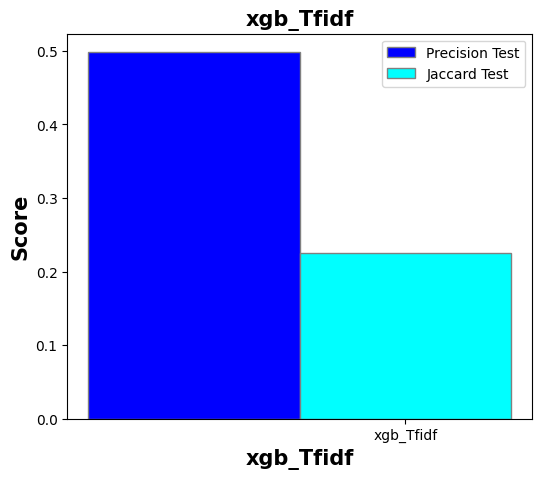

In [30]:
result_xgb_tfidf = stocker_results(name="xgb_Tfidf",precision_test=precision_score(y_test_sample_trans, xgb_binary_predictions,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, xgb_binary_predictions, average='samples'),
                                recall_test = recall_score(y_test_sample_trans, xgb_binary_predictions, average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, xgb_binary_predictions, average='samples'),
                                fit_time=fit_time_xgb, predict_time = predict_time_xgb)

plot_result(result_xgb_tfidf)

In [31]:
mlflow.end_run()

### Random Forest

In [32]:
'''mlflow.start_run(run_name="tfidf_Random Forest")
rf_tfidf = create_random_forest_pipeline()
# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans = rf_tfidf["tfidf"].fit_transform(X_train_sample_str)
X_test_sample_trans = rf_tfidf["tfidf"].transform(X_test_sample_str)
'''

'mlflow.start_run(run_name="tfidf_Random Forest")\nrf_tfidf = create_random_forest_pipeline()\n# Utiliser les chaînes de caractères pour l\'ajustement et la transformation\nX_train_sample_trans = rf_tfidf["tfidf"].fit_transform(X_train_sample_str)\nX_test_sample_trans = rf_tfidf["tfidf"].transform(X_test_sample_str)\n'

In [33]:
'''fit_time_rf =time.time()
rf_tfidf.fit(X_train_sample_str, y_train_sample_trans)
fit_time_rf = time.time() - fit_time_rf
print("Fit time : ", fit_time)

predict_time_rf = time.time()
predictions_rf = rf_tfidf.predict(X_test_sample_str)
predict_time_rf = time.time() - predict_time_rf

mlflow.log_param("min_df", pipeline_tfidf.named_steps['tfidf'].min_df)
mlflow.log_param("max_df", pipeline_tfidf.named_steps['tfidf'].max_df)
mlflow.log_metric("fit_time", fit_time)
mlflow.sklearn.log_model(rf_tfidf, "model")'''

'fit_time_rf =time.time()\nrf_tfidf.fit(X_train_sample_str, y_train_sample_trans)\nfit_time_rf = time.time() - fit_time_rf\nprint("Fit time : ", fit_time)\n\npredict_time_rf = time.time()\npredictions_rf = rf_tfidf.predict(X_test_sample_str)\npredict_time_rf = time.time() - predict_time_rf\n\nmlflow.log_param("min_df", pipeline_tfidf.named_steps[\'tfidf\'].min_df)\nmlflow.log_param("max_df", pipeline_tfidf.named_steps[\'tfidf\'].max_df)\nmlflow.log_metric("fit_time", fit_time)\nmlflow.sklearn.log_model(rf_tfidf, "model")'

In [34]:
'''probabilities = predictions_rf

# Utiliser la fonction pour obtenir les tags prédits
rf_binary_predictions = select_top_n_tags(probabilities, threshold=0.15, top_n=5)'''

'probabilities = predictions_rf\n\n# Utiliser la fonction pour obtenir les tags prédits\nrf_binary_predictions = select_top_n_tags(probabilities, threshold=0.15, top_n=5)'

In [35]:
'''print("Precision:", precision_score(y_test_sample_trans, rf_binary_predictions, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, rf_binary_predictions, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, rf_binary_predictions, average='samples'))
#rf_predictions_labels =mlb.inverse_transform(rf_binary_predictions)
tags_predicted_to_text(rf_binary_predictions, mlb)
print(y_test_sample[:5])'''



'print("Precision:", precision_score(y_test_sample_trans, rf_binary_predictions, average=\'samples\'))\nprint("Recall:", recall_score(y_test_sample_trans, rf_binary_predictions, average=\'samples\'))\nprint("F1 Score:", f1_score(y_test_sample_trans, rf_binary_predictions, average=\'samples\'))\n#rf_predictions_labels =mlb.inverse_transform(rf_binary_predictions)\ntags_predicted_to_text(rf_binary_predictions, mlb)\nprint(y_test_sample[:5])'

In [36]:
'''result_rf_tfidf = stocker_results(name="rf_Tfidf",precision_test=precision_score(y_test_sample_trans, rf_binary_predictions,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, rf_binary_predictions, average='samples'),
                                recall_test = recall_score(y_test_sample_trans, rf_binary_predictions, average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, rf_binary_predictions, average='samples'),
                                fit_time=fit_time_rf, predict_time = predict_time_rf)

plot_result(result_rf_tfidf)'''


'result_rf_tfidf = stocker_results(name="rf_Tfidf",precision_test=precision_score(y_test_sample_trans, rf_binary_predictions,average=\'samples\'),\n                                f1_test=f1_score(y_test_sample_trans, rf_binary_predictions, average=\'samples\'),\n                                recall_test = recall_score(y_test_sample_trans, rf_binary_predictions, average=\'samples\'),\n                                jaccard_test=jaccard_score(y_test_sample_trans, rf_binary_predictions, average=\'samples\'),\n                                fit_time=fit_time_rf, predict_time = predict_time_rf)\n\nplot_result(result_rf_tfidf)'

In [37]:
#mlflow.end_run()

## Embedding avec word2Vec

In [38]:
mlflow.start_run(run_name="Word2Vec")
pipeline_w2v = create_word2vec_pipeline()
# Utiliser les chaînes de caractères pour l'ajustement et la transformation
X_train_sample_trans_w2v = pipeline_w2v['word2vec'].fit_transform(X_train_sample_str)
X_test_sample_trans_w2v = pipeline_w2v['word2vec'].transform(X_test_sample_str)

mlb2 = MultiLabelBinarizer()
y_train_sample_trans = mlb2.fit_transform(y_train_sample)

In [39]:
print(X_train_sample_trans_w2v.shape)
print(X_test_sample_trans_w2v.shape)

(1000, 400)
(200, 400)


In [40]:
fit_time =time.time()
lr_w2v = pipeline_w2v.named_steps['clf_w2v'].fit(X_train_sample_trans_w2v, y_train_sample_trans)
fit_time = time.time() - fit_time


predict_time = time.time()
predictions_w2v = lr_w2v.predict_proba(X_test_sample_trans_w2v)
predict_time = time.time() - predict_time

#mlflow.log_param("vector_size", pipeline_w2v.named_steps['word2vec'].vector_size)
#mlflow.log_param("window", pipeline_w2v.named_steps['word2vec'].window)
mlflow.log_metric("fit_time", fit_time)
mlflow.sklearn.log_model(lr_tfidf, "model")



/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test,Fit Time,predict_time
0,lr_w2v,0.147,0.248333,0.176587,0.102107,7.769903,0.211144


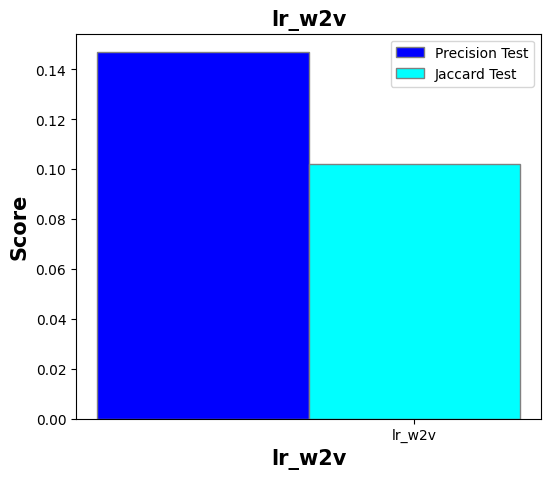

In [41]:
probabilities = predictions_w2v

# Utiliser la fonction pour obtenir les tags prédits
rf_w2v_binary_predictions = select_top_n_tags(probabilities, threshold=0.1, top_n=5)

tags_predicted_to_text(rf_w2v_binary_predictions, mlb2)
result_lr_w2v = stocker_results(name="lr_w2v",precision_test=precision_score(y_test_sample_trans, rf_w2v_binary_predictions,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, rf_w2v_binary_predictions,average='samples'),
                                recall_test = recall_score(y_test_sample_trans, rf_w2v_binary_predictions,average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'),
                                fit_time=fit_time, predict_time = predict_time)

plot_result(result_lr_w2v)

In [42]:
print("Precision:", precision_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, rf_w2v_binary_predictions, average='samples'))

Precision: 0.147
Recall: 0.24833333333333335
F1 Score: 0.17658730158730163


In [43]:
mlflow.end_run()

### BERT Embedding

"Bidirectional Encoder Representations from Transformers":  

BERT est un modèle de langage bidirectionnel basé sur des transformers, capable de capturer les relations complexes entre les mots en utilisant le contexte gauche-droite et droite-gauche pour générer des embeddings riches en informations pour chaque mot.

In [44]:
'''mlflow.start_run(run_name="BERT")
pipeline_bert = create_bert_pipeline()

# Utiliser les chaînes de caractères pour l'ajustement et la transformation
vec_time =time.time()
X_train_sample_trans_bert = pipeline_bert['bert_vectorizer'].fit_transform(X_train_sample_str)
X_test_sample_trans_bert = pipeline_bert['bert_vectorizer'].transform(X_test_sample_str)
vec_time = time.time() - vec_time
mlflow.log_metric("vec_time", vec_time)
mlb3 = MultiLabelBinarizer()
y_train_sample_trans = mlb3.fit_transform(y_train_sample) '''

'mlflow.start_run(run_name="BERT")\npipeline_bert = create_bert_pipeline()\n\n# Utiliser les chaînes de caractères pour l\'ajustement et la transformation\nvec_time =time.time()\nX_train_sample_trans_bert = pipeline_bert[\'bert_vectorizer\'].fit_transform(X_train_sample_str)\nX_test_sample_trans_bert = pipeline_bert[\'bert_vectorizer\'].transform(X_test_sample_str)\nvec_time = time.time() - vec_time\nmlflow.log_metric("vec_time", vec_time)\nmlb3 = MultiLabelBinarizer()\ny_train_sample_trans = mlb3.fit_transform(y_train_sample) '

In [45]:
'''fit_time =time.time()
lr_bert = pipeline_bert.named_steps['clf_bert'].fit(X_train_sample_trans_bert, y_train_sample_trans)
fit_time = time.time() - fit_time

predict_time = time.time()
predictions_bert = lr_bert.predict_proba(X_test_sample_trans_bert)
predict_time = time.time() - predict_time

binary_pred_bert =select_top_n_tags(predictions_bert, threshold=0.1, top_n=5)
tags_predicted_to_text(binary_pred_bert, mlb3)
print("Precision:", precision_score(y_test_sample_trans, binary_pred_bert, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, binary_pred_bert, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, binary_pred_bert, average='samples'))'''



'fit_time =time.time()\nlr_bert = pipeline_bert.named_steps[\'clf_bert\'].fit(X_train_sample_trans_bert, y_train_sample_trans)\nfit_time = time.time() - fit_time\n\npredict_time = time.time()\npredictions_bert = lr_bert.predict_proba(X_test_sample_trans_bert)\npredict_time = time.time() - predict_time\n\nbinary_pred_bert =select_top_n_tags(predictions_bert, threshold=0.1, top_n=5)\ntags_predicted_to_text(binary_pred_bert, mlb3)\nprint("Precision:", precision_score(y_test_sample_trans, binary_pred_bert, average=\'samples\'))\nprint("Recall:", recall_score(y_test_sample_trans, binary_pred_bert, average=\'samples\'))\nprint("F1 Score:", f1_score(y_test_sample_trans, binary_pred_bert, average=\'samples\'))'

In [46]:
'''result_lr_bert = stocker_results(name="lr_bert",precision_test=precision_score(y_test_sample_trans, binary_pred_bert,average='samples'),
                                f1_test=f1_score(y_test_sample_trans, binary_pred_bert,average='samples'),
                                recall_test = recall_score(y_test_sample_trans, binary_pred_bert,average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, binary_pred_bert, average='samples'),
                                fit_time=fit_time, predict_time = predict_time)

plot_result(result_lr_bert)
mlflow.end_run()'''

'result_lr_bert = stocker_results(name="lr_bert",precision_test=precision_score(y_test_sample_trans, binary_pred_bert,average=\'samples\'),\n                                f1_test=f1_score(y_test_sample_trans, binary_pred_bert,average=\'samples\'),\n                                recall_test = recall_score(y_test_sample_trans, binary_pred_bert,average=\'samples\'),\n                                jaccard_test=jaccard_score(y_test_sample_trans, binary_pred_bert, average=\'samples\'),\n                                fit_time=fit_time, predict_time = predict_time)\n\nplot_result(result_lr_bert)\nmlflow.end_run()'

## USE embbedding

In [47]:
mlflow.start_run(run_name="USE")
pipeline_use = create_use_pipeline()

# Utiliser les chaînes de caractères pour l'ajustement et la transformation
vec_time =time.time()
X_train_sample_trans_use = pipeline_use['use_vectorizer'].fit_transform(X_train_sample_str)
X_test_sample_trans_use = pipeline_use['use_vectorizer'].transform(X_test_sample_str)
vec_time = time.time() - vec_time
mlflow.log_metric("vec_time", vec_time)
mlb4 = MultiLabelBinarizer()
y_train_sample_trans = mlb4.fit_transform(y_train_sample)

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [48]:
fit_time =time.time()
lr_use = pipeline_use.named_steps['clf_use'].fit(X_train_sample_trans_use, y_train_sample_trans)
fit_time = time.time() - fit_time

predict_time = time.time()
predictions_use = lr_use.predict_proba(X_test_sample_trans_use)
predict_time = time.time() - predict_time


binary_pred_use =select_top_n_tags(predictions_use, threshold=0.15, top_n=5)
tags_predicted_to_text(binary_pred_use, mlb4)
print("Precision:", precision_score(y_test_sample_trans, binary_pred_use, average='samples'))
print("Recall:", recall_score(y_test_sample_trans, binary_pred_use, average='samples'))
print("F1 Score:", f1_score(y_test_sample_trans, binary_pred_use, average='samples'))

Precision: 0.6655833333333334
Recall: 0.376
F1 Score: 0.44676190476190475


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test,Fit Time,predict_time
0,lr_use,0.665583,0.376,0.446762,0.316476,8.31044,0.210432


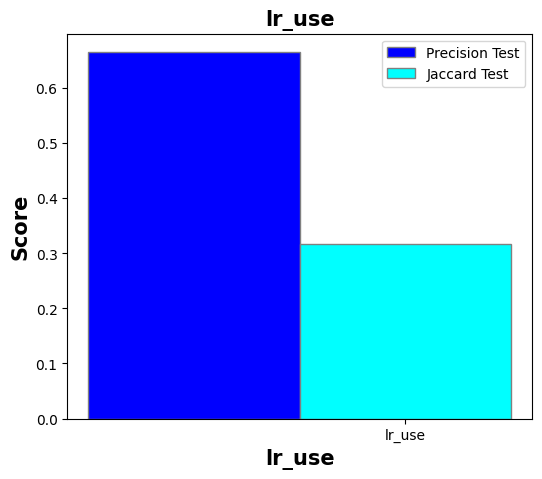

In [49]:
result_lr_use = stocker_results(name="lr_use",precision_test=precision_score(y_test_sample_trans, binary_pred_use, average='samples'),
                                f1_test=f1_score(y_test_sample_trans, binary_pred_use,average='samples'),
                                recall_test = recall_score(y_test_sample_trans, binary_pred_use,average='samples'),
                                jaccard_test=jaccard_score(y_test_sample_trans, binary_pred_use, average='samples'),
                                fit_time=fit_time, predict_time = predict_time)

plot_result(result_lr_use)
mlflow.end_run()

## Comparaison des différentes modélisation.

In [50]:
mlflow.start_run(run_name="Comparaison")
df =pd.concat([result_lr_tfidf,result_xgb_tfidf, result_lr_w2v,  result_lr_use]) #result_lr_bert,result_rf_tfidf,
display(df)
df.to_csv("Data/df_results.csv", index=False)
mlflow.log_artifact("Data/df_results.csv")

,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test,Fit Time,predict_time
0,lr_Tfidf,0.527500,0.202417,0.276464,0.192667,8.126969,0.123057
0,xgb_Tfidf,0.498667,0.254750,0.313115,0.225185,52.951246,0.217425
0,lr_w2v,0.147000,0.248333,0.176587,0.102107,7.769903,0.211144
0,lr_use,0.665583,0.376000,0.446762,0.316476,8.310440,0.210432


,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test
0,lr_Tfidf,0.527500,0.202417,0.276464,0.192667
0,xgb_Tfidf,0.498667,0.254750,0.313115,0.225185
0,lr_w2v,0.147000,0.248333,0.176587,0.102107
0,lr_use,0.665583,0.376000,0.446762,0.316476


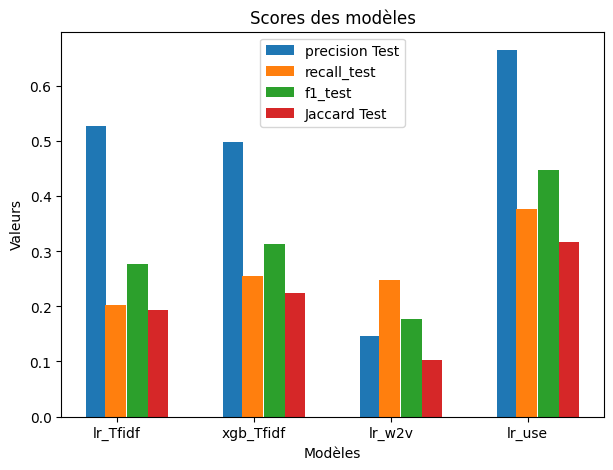

In [51]:
all_result = df.loc[:,['Vectorizer', 'precision Test', 'recall_test','f1_test','Jaccard Test']]

display(all_result)

# Plot
width = 0.15  # Largeur des barres
fig, ax = plt.subplots(figsize=(7, 5))
x = np.arange(len(all_result))  # Emplacements des barres

# Plot pour chaque modèle et chaque métrique

rects1 = ax.bar(x - width/1, all_result['precision Test'], width, label='precision Test')
rects2 = ax.bar(x - width/15, all_result['recall_test'], width, label='recall_test')
rects3 = ax.bar(x + width/1, all_result['f1_test'], width, label='f1_test')
rects4 = ax.bar(x + width/0.5, all_result['Jaccard Test'], width, label='Jaccard Test')

# Ajouter des étiquettes, des titres, etc.
ax.set_ylabel('Valeurs')
ax.set_xlabel('Modèles')
ax.set_title('Scores des modèles')
ax.set_xticks(x)
ax.set_xticklabels(all_result['Vectorizer'])
ax.legend()
plt.savefig("Data/Comparaison.png")
plt.show()
mlflow.log_artifact("Data/Comparaison.png")

In [52]:
mlflow.end_run()

## Essais: Vectorisation:USE, régréssion logistique 

In [53]:
mlflow.start_run(run_name="final_model")

<ActiveRun: >

In [54]:
# Instanciation de MLB et transformation des labels
mlb_final = MultiLabelBinarizer()
y_train_trans = mlb_final.fit_transform(y_train)
y_test_trans = mlb_final.transform(y_test) 

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['aar', 'absl-py', 'abstractmethoderror', 'access-point', 'accessibility-api', 'acrobat', 'actionbardrawertoggle', 'activation', 'activedirectorymembership', 'activityresultcontracts', 'add-on', 'addslashes', 'aescryptoserviceprovider', 'ajax.net', 'alfresco', 'all-files', 'ambiguity', 'anchor-cms', 'android-6.0.1-marshmallow', 'android-assetmanager', 'android-chrome', 'android-diffutils', 'android-ffmpeg', 'android-inputtype', 'android-intent-chooser', 'android-jetpack-compose-gesture', 'android-listadapter', 'android-media3', 'android-mnc', 'android-network-security-config', 'android-photoview', 'android-runtime', 'android-scripting', 'android-sharing', 'android-textview-autosize', 'android-togglebutton', 'android-update-sdk', 'android-viewtreeobserver', 'android-wireless', 'angular-bootstrap', 'angular-cli-v8', 'angular-cookies', 'angular-formbuilder', 'an

In [55]:
pip_reg_log = create_use_pipeline()


X_train_str = [' '.join(text) for text in X_train]
X_test_str = [' '.join(text) for text in X_test]

vec_time =time.time()
X_train_trans = pip_reg_log["use_vectorizer"].fit_transform(X_train_str)
X_test_trans = pip_reg_log["use_vectorizer"].transform(X_test_str)
vec_time = time.time() - vec_time


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [56]:
fit_time =time.time()
lr_use_final = pip_reg_log.named_steps['clf_use'].fit(X_test_trans, y_test_trans)
fit_time = time.time() - fit_time  

predict_time = time.time()
binary_final_pred = lr_use_final.predict_proba(X_test_trans)
predict_time = time.time() - predict_time

mlflow.log_metric("vec_time", vec_time)
mlflow.log_metric("fit_time", fit_time)
#mlflow.log.metric("pred_time", predict_time)


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 2 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/opt

In [57]:
binary_final_pred = select_top_n_tags(binary_final_pred, threshold=0.2, top_n=7)

In [58]:
# Calcul des scores
precision_test = precision_score(y_test_trans, binary_final_pred, average='samples')
recall_test = recall_score(y_test_trans, binary_final_pred, average='samples')
f1_test = f1_score(y_test_trans, binary_final_pred, average='samples')
jaccardScore =jaccard_score(y_test_trans, binary_final_pred, average='samples')
print("Jaccard Score:" , jaccardScore)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)


/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Jaccard Score: 0.34515413322366867
Precision: 0.740886014918177
Recall: 0.3948853484216796
F1 Score: 0.48568064934205496


In [59]:
tags_predicted_to_text(binary_final_pred, mlb_final)

/opt/anaconda3/envs/supervisedP5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vectorizer,precision Test,recall_test,f1_test,Jaccard Test,Fit Time,predict_time
0,use_lr_final_model,0.740886,0.394885,0.485681,0.345154,172.574622,12.145249


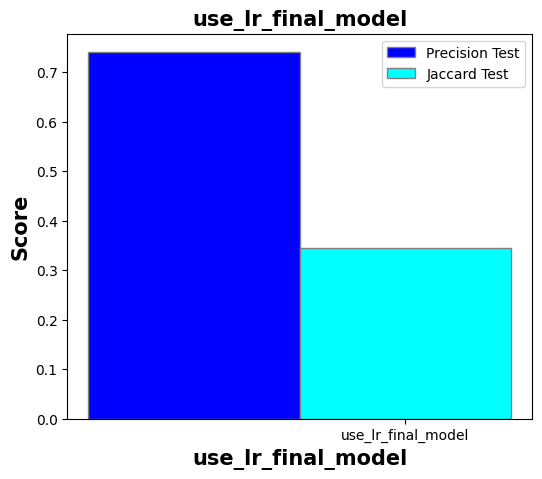

In [60]:
result_final_model = stocker_results(name="use_lr_final_model", 
                                precision_test=precision_score(y_test_trans, binary_final_pred, average='samples'),
                                f1_test=f1_score(y_test_trans, binary_final_pred, average='samples'),
                                recall_test = recall_score(y_test_trans, binary_final_pred, average='samples'),
                                jaccard_test=jaccard_score(y_test_trans, binary_final_pred, average='samples'), 
                                fit_time=fit_time, predict_time = predict_time)

plot_result(result_final_model)
mlflow.end_run()